# Accessibility Index

Notebook with accessibility index calculations

## Import modules

In [ ]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
%matplotlib inline

## Import color styles

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

## Download municipality limits

In [3]:
#gdf = aup.gdf_from_db("mpos_2020", "marco")
mpos = ['01001','01005','01011']
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()
for m in mpos:
    query = f"SELECT * FROM processed.hex_bins_dist_2020 WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [4]:
print(hex_bins.shape)
hex_bins.head(2)

(2088, 6)


,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,"POLYGON ((-102.31192 21.70346, -102.30734 21.7...",88498eae51fffff,01001,6013.5785,17233.9935,5827.3075
1,"POLYGON ((-102.12527 21.99781, -102.12576 22.0...",88498e22e3fffff,01001,0.0000,0.0000,0.0000


<AxesSubplot:>

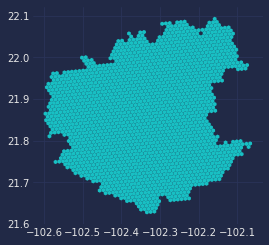

In [5]:
hex_bins.plot()

In [6]:
print(mun_gdf.shape)
mun_gdf.head(2)

(3, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0..."
0,01005,01,005,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0..."


<AxesSubplot:>

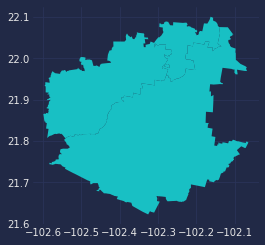

In [7]:
mun_gdf.plot()

## Download nodes

In [8]:
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [9]:
query = f"SELECT * FROM processed.nodes_dist_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(49955, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,759682506,-102.289874,21.978078,POINT (-102.28987 21.97808),573.558,4214.656,1022.648


<AxesSubplot:>

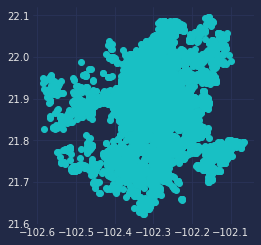

In [10]:
nodes.plot()

## Index calculation

### Nodes

In [12]:
nodes_filter = nodes.loc[(nodes['dist_supermercados'] > 0) &
                        (nodes['dist_farmacia'] > 0) &
                        (nodes['dist_hospitales'] > 0)].copy()
print(nodes_filter.shape)
nodes_filter.head(2)

(49086, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,759682506,-102.289874,21.978078,POINT (-102.28987 21.97808),573.558,4214.656,1022.648


In [13]:
#removes big distance values to avoid errors
nodes_filter['dist_supermercados'] = nodes_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
nodes_filter['dist_farmacia'] = nodes_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
nodes_filter['ind_hospitales'] =  nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
nodes_filter['ind_supermercado'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
nodes_filter['ind_farmacias'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
nodes_filter['ind_accesibilidad'] = nodes_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

In [14]:
nodes_filter.head(2)

,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados,ind_hospitales,ind_supermercado,ind_farmacias,ind_accesibilidad
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373,0.924775,0.932250,0.878941,0.911955
1,759682506,-102.289874,21.978078,POINT (-102.28987 21.97808),573.558,4214.656,1022.648,0.208427,0.087912,0.617721,0.305000


Plotting

<AxesSubplot:>

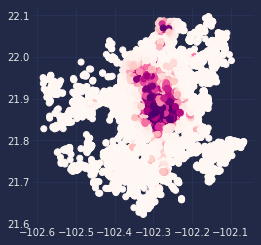

In [15]:
nodes_filter.plot(nodes_filter.ind_accesibilidad)

### Hexagons

In [16]:
hex_filter = hex_bins.loc[(hex_bins['dist_supermercados'] > 0) &
                        (hex_bins['dist_farmacia'] > 0) &
                        (hex_bins['dist_hospitales'] > 0)].copy()
print(hex_filter.shape)
hex_filter.head(2)

(1295, 6)


,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,"POLYGON ((-102.25008 21.82169, -102.25058 21.8...",88498eadd1fffff,01001,2429.5690,4126.9620,2212.9810
1,"POLYGON ((-102.31192 21.70346, -102.30734 21.7...",88498eae51fffff,01001,6013.5785,17233.9935,5827.3075


In [17]:
#removes big distance values to avoid errors
hex_filter['dist_supermercados'] = hex_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
hex_filter['dist_farmacia'] = hex_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
hex_filter['ind_hospitales'] =  hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
hex_filter['ind_supermercado'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
hex_filter['ind_farmacias'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
hex_filter['ind_accesibilidad'] = hex_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

Plotting

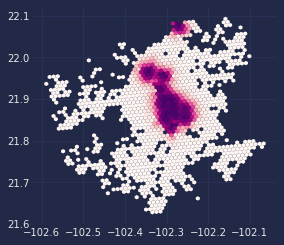

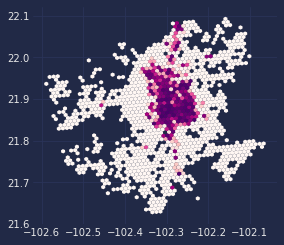

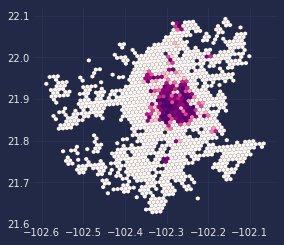

In [18]:
ind = ['ind_hospitales','ind_supermercado','ind_farmacias']
for i in ind:
    hex_filter.plot(hex_filter[i])

In [19]:
hex_filter.ind_accesibilidad.mean()

0.11643512198920729

In [20]:
nodes_filter.ind_accesibilidad.mean()

0.4425886174343631

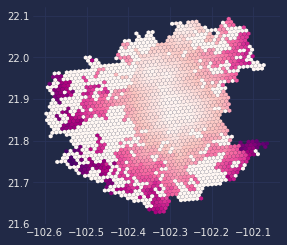

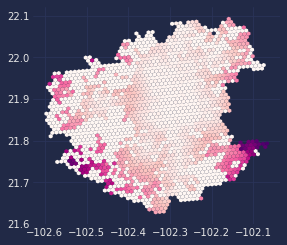

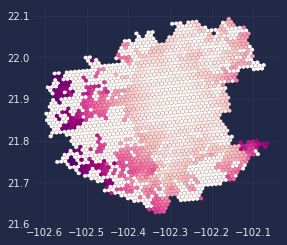

In [21]:
ind = ['dist_hospitales','dist_supermercados','dist_farmacia']
for i in ind:
    hex_bins.plot(hex_bins[i])

## Data distribution analysis

Accessibility index

<AxesSubplot:>

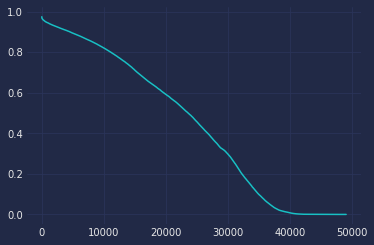

In [22]:
nodes_filter.sort_values(by='ind_accesibilidad', ascending=False, inplace=True)
nodes_filter.reset_index(inplace=True)
nodes_filter.drop(columns=['index'], inplace=True)
nodes_filter.ind_accesibilidad.plot()

Distance to pharmacies

<AxesSubplot:>

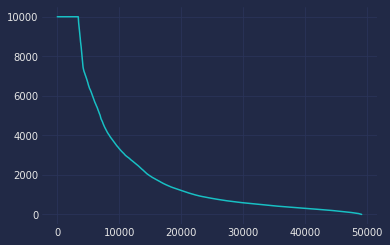

In [23]:
nodes_filter.sort_values(by='dist_farmacia', ascending=False, inplace=True)
nodes_filter.reset_index(inplace=True)
nodes_filter.drop(columns=['index'], inplace=True)
nodes_filter.dist_farmacia.plot()

Pharmacy index]

<AxesSubplot:>

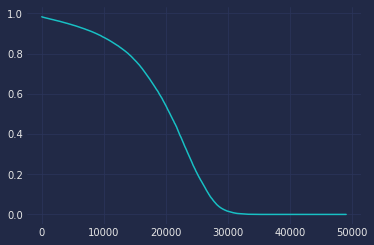

In [25]:
nodes_filter.sort_values(by='ind_farmacias', ascending=False, inplace=True)
nodes_filter.reset_index(inplace=True)
nodes_filter.drop(columns=['index'], inplace=True)
nodes_filter.ind_farmacias.plot()

## Output graphs

### Sigmoidal function

In [35]:
df_tmp = pd.DataFrame(np.random.randint(0,5000,size=(10000,1)), columns=list('A'))
df_tmp['ind_A'] = df_tmp.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['A'] - 650 ))), axis=1)
df_tmp.head(2)

,A,ind_A
0,981,1.112590e-01
1,2998,3.966435e-07


<AxesSubplot:>

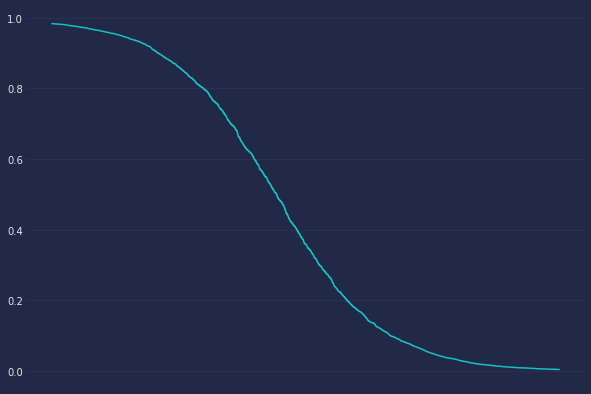

In [51]:
fig,ax = plt.subplots(figsize=(10,7))
df_tmp.sort_values(by='ind_A', ascending=False, inplace=True)
df_tmp.reset_index(inplace=True)
df_tmp.drop(columns=['index'], inplace=True)
ax.axes.get_xaxis().set_visible(False)
df_tmp.iloc[:3000].ind_A.plot(ax=ax)

### Territory

Download edges

In [11]:
edges_query =  f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(edges_query, geometry_col='geometry')
edges.head(2)

,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,713153965,1408187972,301189389,0,False,None,Constitución,residential,None,13.812,"LINESTRING (-102.34221 21.84854, -102.34219 21...",None,None,None,None,None,None,None
1,715583650,301191695,301189389,0,False,None,Constitución,residential,None,17.008,"LINESTRING (-102.34221 21.84854, -102.34223 21...",None,None,None,None,None,None,None


Clip edges to a specific hexagon

In [83]:
hex_bins = hex_bins.set_crs("EPSG:4326")
nodes_c = gpd.clip(nodes, hex_bins.loc[hex_bins.hex_id_8=='88498eac91fffff'])
edges_c = gpd.clip(edges, hex_bins.loc[hex_bins.hex_id_8=='88498eac91fffff'])

Plot edges and nodes within hexagon

<AxesSubplot:>

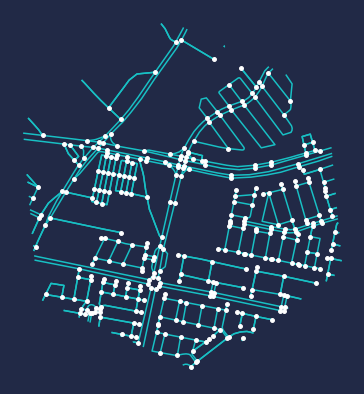

In [99]:
fig,ax = plt.subplots(figsize=(10,7))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
nodes_c.plot(ax=ax, color='white', markersize=15, zorder=1)
edges_c.plot(ax=ax, zorder=-1)

### Population vs Territory Index

Municipality geographic codes

In [118]:
 cities = {"Aguascalientes":{"mpos":["01001","01005","01011"],"edo":["01"]},
"Tijuana":{"mpos":["02003", "02004", "02005"],"edo":["02"]},
"León":{"mpos":["11020", "11037"],"edo":["11"]},
"Pachuca":{"mpos":["13022", "13039", "13048", "13051", "13052", "13082", "13083"],"edo":["13"]},
"Guadalajara":{"mpos":["14002", "14039", "14044", "14051", "14070", "14097", "14098", "14101", "14120", "14124"],"edo":["14"]},
"Toluca":{"mpos":["15005", "15018", "15027", "15051", "15054", "15055", "15062", "15067", "15072", "15073", "15076", "15087", "15090", "15106", "15115", "15118"],"edo":["15"]},
"Morelia":{"mpos":["16022", "16053", "16088"],"edo":["16"]},
"Monterrey":{"mpos":["19001", "19006", "19009", "19010", "19012", "19018", "19019", "19021", "19025", "19026", "19031", "19039", "19041", "19045", "19046", "19047", "19048", "19049"],"edo":["19"]},
"Puebla":{"mpos":["21001", "21015", "21034", "21041", "21048", "21060", "21074", "21090", "21106", "21114", "21119", "21122", "21125", "21132", "21136", "21140", "21143", "21163", "21181", "29015", "29017", "29019", "29023", "29025", "29027", "29028", "29029", "29032", "29041", "29044", "29051", "29053", "29054", "29056", "29057", "29058", "29059"],"edo":["21", "29"]},
"Querétaro":{"mpos":["11004", "22006", "22008", "22011", "22014"],"edo":["11", "22"]},
"Cancún":{"mpos":["23003", "23005"],"edo":["23"]},
"Mérida":{"mpos":["31002", "31013", "31038", "31041", "31050", "31063" , "31090", "31093", "31095", "31100", "31101"],"edo":["31"]},
"CDMX":{"mpos":["09002", "09003", "09004", "09005", "09006", "09007", "09008", "09009", "09010", "09011", "09012", "09013", "09014", "09015", "09016", "09017"],"edo":["09"]}
}

Create table with calculated index by territory and popolation

In [126]:
# create dataframe to append indexes
df_idx = pd.DataFrame(columns=['city','territory',
                               'w_territory','w_population_t',
                               'w_population','population'])
# create geodataframe to append hexagons
hex_all = gpd.GeoDataFrame()

i = 0
for city in cities:
    hex_bins_idx = gpd.GeoDataFrame() # hexagon with index data
    hex_bins_pop = gpd.GeoDataFrame() # hexagon with population data
    
    # download hexagons grom database
    for c in cities[city]['mpos']:
        query = f"SELECT * FROM processed.hex_bins_index_2020 WHERE \"CVEGEO\" LIKE \'{c}%%\'"
        hex_bins_idx = hex_bins_idx.append(aup.gdf_from_query(query, geometry_col='geometry'))
        query = f"SELECT pobtot,hex_id_8,geometry FROM processed.hex_bins_pop WHERE \"CVEGEO\" LIKE \'{c}%%\'"
        hex_bins_pop = hex_bins_pop.append(aup.gdf_from_query(query, geometry_col='geometry'))
        
    hex_mrg = pd.merge(hex_bins_idx, hex_bins_pop, on='hex_id_8')
    
    #node counter for weighted index by nodes
    node_sum = hex_mrg['node_count'].sum()
    #calculating weigths by hex_bin
    hex_mrg['wAcc'] = hex_mrg.idx_accessibility * hex_mrg['node_count']
    #calculating input for weigthed average
    hex_mrg['idx_accessibility_wavg'] = hex_mrg['wAcc']/node_sum
    
    w_ter_idx = round(hex_mrg.idx_accessibility_wavg.sum(), 2)

    pop_idx_t = round(hex_mrg.loc[
        (hex_mrg.pobtot>0),'idx_accessibility_wavg'].sum(), 2)
    
    # calculate weighted average by population size
    pobtot = hex_mrg.pobtot.sum()
    hex_mrg['wPob'] = hex_mrg.idx_accessibility * hex_mrg.pobtot
    hex_mrg['idx_accessibility_wAvgPob'] = hex_mrg.wPob / pobtot
    w_pop_idx = hex_mrg.idx_accessibility_wAvgPob.sum()
    
    ter_idx = hex_mrg.idx_accessibility.mean()
    pob_idx = hex_mrg.loc[hex_mrg.pobtot>0]['idx_accessibility'].mean()
    
    df_idx.loc[i] = [city, ter_idx, w_ter_idx, 
                     pop_idx_t, w_pop_idx, pob_idx]
    
    hex_mrg['city'] = city
    hex_mrg.rename(columns={'geometry_x':'geometry'}, inplace=True)
    hex_all = hex_all.append(hex_mrg)

    i += 1

DataFrame with indexes by city and different calculation methods

In [127]:
df_idx

,city,territory,w_territory,w_population_t,w_population,population
0,Aguascalientes,0.118568,0.44,0.43,0.624584,0.445318
1,Tijuana,0.169743,0.49,0.49,0.590543,0.462582
2,León,0.160288,0.48,0.47,0.687431,0.470186
3,Pachuca,0.147644,0.43,0.41,0.597101,0.405054
4,Guadalajara,0.209183,0.55,0.54,0.677183,0.490277
5,Toluca,0.177189,0.42,0.41,0.580934,0.398911
6,Morelia,0.137086,0.46,0.45,0.668577,0.429964
7,Monterrey,0.199461,0.54,0.54,0.659037,0.473088
8,Puebla,0.239734,1.00,0.49,0.607236,0.391792
9,Querétaro,0.118959,0.42,0.41,0.626551,0.395094


Manual index calculation for testing

In [197]:
df_idx['w_territory_manual'] = np.nan
df_idx['w_popterr_manual'] = np.nan
for c_2 in df_idx.city.unique():
    hex_city_tmp = hex_all.loc[(hex_all.city==c_2)].copy()
    #node counter for weighted index
    node_sum = hex_city_tmp['node_count'].sum()
    #calculating weigths by hex_bin
    hex_city_tmp['wAcc'] = hex_city_tmp.idx_accessibility * hex_city_tmp['node_count']
    #calculating input for weigthed average
    hex_city_tmp['idx_Acc_m'] = (hex_city_tmp['wAcc']/node_sum)
    w_t_idx_m = hex_city_tmp['idx_Acc_m'].sum()
    w_pt_idx_m = hex_city_tmp.loc[hex_city_tmp.pobtot>0]['idx_Acc_m'].sum()
    df_idx.loc[df_idx.city==c_2,'w_territory_manual'] = w_t_idx_m
    df_idx.loc[df_idx.city==c_2,'w_popterr_manual'] = w_pt_idx_m

In [198]:
df_idx

,city,territory,w_territory,w_population_t,w_population,population,w_territory_manual,w_popterr_manual
9,Querétaro,0.118959,0.42,0.41,0.626551,0.395094,0.416616,0.405136
5,Toluca,0.177189,0.42,0.41,0.580934,0.398911,0.420111,0.408074
3,Pachuca,0.147644,0.43,0.41,0.597101,0.405054,0.426119,0.405540
11,Mérida,0.151239,0.43,0.43,0.583934,0.409944,0.431850,0.425926
0,Aguascalientes,0.118568,0.44,0.43,0.624584,0.445318,0.443304,0.433273
6,Morelia,0.137086,0.46,0.45,0.668577,0.429964,0.456530,0.449107
2,León,0.160288,0.48,0.47,0.687431,0.470186,0.484737,0.472328
1,Tijuana,0.169743,0.49,0.49,0.590543,0.462582,0.494035,0.485635
8,Puebla,0.239734,1.00,0.49,0.607236,0.391792,0.499532,0.247170
10,Cancún,0.219298,0.52,0.51,0.656826,0.440183,0.522644,0.514328


Plot difference between territory and population proximity index

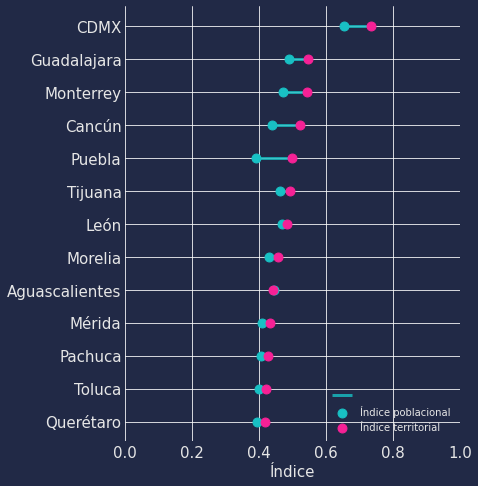

In [196]:
#import seaborn as sns

df_idx.sort_values(by='w_territory_manual', inplace=True)

fig = plt.figure(figsize=(6,8))

my_range=range(0,len(df_idx))

plt.hlines(y=df_idx['city'], xmin=df_idx['population'], xmax=df_idx['w_territory_manual'],linewidth=3, alpha =0.8)

plt.scatter(df_idx['population'], my_range, s=80, alpha=1)

plt.scatter(df_idx['w_territory_manual'], my_range, s=80, alpha=1, zorder=2)

#plt.title("Índice de proximidad básica en cuarentena", fontsize=20, x=0.5,y=1.02)

plt.xlabel('Índice', fontsize=15)

plt.ylabel('',fontsize=20)

plt.yticks(fontsize=15)

plt.xticks(fontsize=15)

plt.grid(c='white')

plt.xlim(left=0, right=1) 

plt.legend(['', 'Índice poblacional', 'Índice territorial'], loc='lower right')

## Querétaro and CDMX plots

In [199]:
 cities = {
"Queretaro":{"mpos":["11004", "22006", "22008", "22011", "22014"],"edo":["11", "22"]},
"CDMX":{"mpos":["09002", "09003", "09004", "09005", "09006", "09007", "09008", "09009", "09010", "09011", "09012", "09013", "09014", "09015", "09016", "09017"],"edo":["09"]}
}

#### Querétaro

In [214]:
city_codes = cities['Queretaro']['mpos']
# donwload hex bins with indexes
query = f'SELECT * FROM processed.hex_bins_index_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
hex_qto = aup.gdf_from_query(query, geometry_col='geometry')
# download municipality geometries
query = f'SELECT * FROM marco.mpos_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
mun_qto = aup.gdf_from_query(query, geometry_col='geometry')

In [256]:
# create polygon for spatial query
gdf_tmp = mun_qto.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [257]:
# download edges according to municipality limits
edges_query =  f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(edges_query, geometry_col='geometry')
edges.head(2)

,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,343329633,415144261,366298448,0,True,3,Calle Epigmenio González,tertiary,None,12.044,"LINESTRING (-100.40199 20.61302, -100.40209 20...",None,None,None,None,None,None,None
1,32566416,2468131858,366298448,0,True,2,Prolongación Ezequiel Montes,tertiary,None,15.672,"LINESTRING (-100.40199 20.61302, -100.40204 20...",None,None,None,None,None,8,None


Plot

<AxesSubplot:>

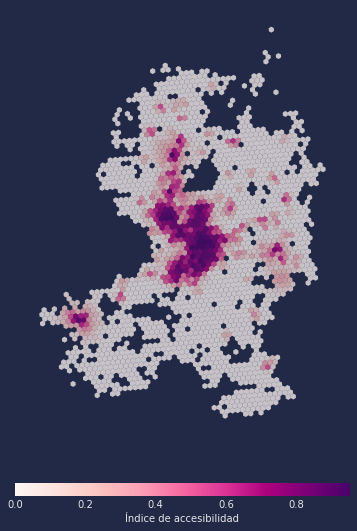

In [269]:
fig,axes = plt.subplots(2,1, figsize=(6,9), gridspec_kw={"height_ratios":[0.96, 0.03]})
ax = axes[0]
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#hex_qto.plot('idx_accessibility',ax=ax,alpha=0.65)
#edges.plot(color='white', linewidth=0.035, ax=ax, zorder=2)
hex_qto.plot(ax=ax, column='idx_accessibility', alpha=0.75, cax=axes[1], legend=True,
             legend_kwds={'label': "Índice de accesibilidad",'orientation': "horizontal"})

#### CDMX

In [243]:
city_codes = cities['CDMX']['mpos']

query = f'SELECT * FROM processed.hex_bins_index_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
hex_cdmx = aup.gdf_from_query(query, geometry_col='geometry')

query = f'SELECT * FROM marco.mpos_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
mun_cdmx = aup.gdf_from_query(query, geometry_col='geometry')

In [244]:
gdf_tmp = mun_cdmx.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [245]:
edges_query =  f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(edges_query, geometry_col='geometry')
edges.head(1)

,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,39563633,6150391153,474201339,0,False,None,Avenida La Turba,secondary,None,73.686,"LINESTRING (-99.06342 19.29845, -99.06302 19.2...",None,None,None,None,None,None,None


<AxesSubplot:>

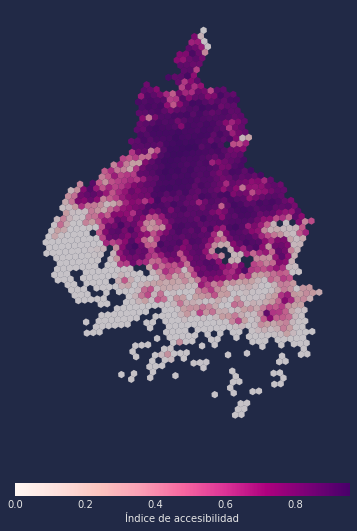

In [268]:
fig,axes = plt.subplots(2,1, figsize=(6,9), gridspec_kw={"height_ratios":[0.96, 0.03]})
ax = axes[0]
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#hex_qto.plot('idx_accessibility',ax=ax,alpha=0.65)
#edges.plot(color='white', linewidth=0.035, ax=ax, zorder=2)
hex_cdmx.plot(ax=ax, column='idx_accessibility', alpha=0.75, cax=axes[1], legend=True,
             legend_kwds={'label': "Índice de accesibilidad",'orientation': "horizontal"})